# Models Analysis



The aim of this notebook is to analyze the models performance using Accuracy, Loss and ROC AUC score. The f1-index was insted already calculated in each model netbook.

In [ ]:
import numpy as np
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import matplotlib.pyplot as plt
import os
from tqdm.auto import tqdm
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


## Download and prepare the dataset



The dataset is divided in two folders: training and test with ratio 0.9 and 0.1.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Unzip the dataset

In [ ]:
!unzip /content/drive/Shareddrives/Progetto_CIDL/Dataset_4c_avg.zip -d .

Archive:  /content/drive/Shareddrives/Progetto_CIDL/Dataset_4c_avg.zip
   creating: ./Dataset_4c_avg/test/
   creating: ./Dataset_4c_avg/test/Amanita/
  inflating: ./Dataset_4c_avg/test/Amanita/006_862rFWvLb4I.jpg  
  inflating: ./Dataset_4c_avg/test/Amanita/008_euaqSUZFtMY.jpg  
  inflating: ./Dataset_4c_avg/test/Amanita/016_S-Z6ZIo2G3k.jpg  
  inflating: ./Dataset_4c_avg/test/Amanita/018_fu20lV1Ks10.jpg  
  inflating: ./Dataset_4c_avg/test/Amanita/019_dC7dMPodoSA.jpg  
  inflating: ./Dataset_4c_avg/test/Amanita/021_2-PKYWYCnqU.jpg  
  inflating: ./Dataset_4c_avg/test/Amanita/029_EZRk61kOaKI.jpg  
  inflating: ./Dataset_4c_avg/test/Amanita/033_p_kC9KT-lGU.jpg  
  inflating: ./Dataset_4c_avg/test/Amanita/037_xyM5ztH9BRk.jpg  
  inflating: ./Dataset_4c_avg/test/Amanita/050_ag9Ii9vTCdA.jpg  
  inflating: ./Dataset_4c_avg/test/Amanita/058_qwNykVN8aEo.jpg  
  inflating: ./Dataset_4c_avg/test/Amanita/069_szzmCkEtJbo.jpg  
  inflating: ./Dataset_4c_avg/test/Amanita/071_SDRvTCrFXG8.jpg  
  in

In [ ]:
# TensorFlow settings

BATCH_SIZE = 64
IMAGE_HEIGHT = 299
IMAGE_WIDTH = 299
IMG_SIZE = 299

NUM_CLASSES = 4

Now we divide the training dataset into training and validation images, to perform a better training of the network.

In [ ]:
# Path to the folder with 9 classes of images:
# data_path = './Dataset'
# data_path = './Dataset_4_classes'
data_path = './Dataset_4c_avg/'

Class used: 4


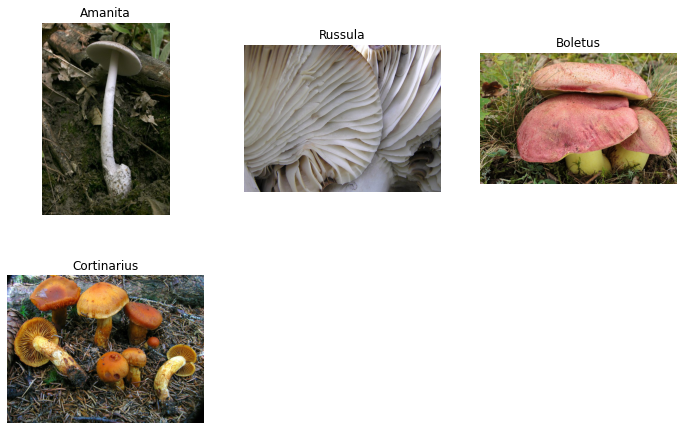

In [ ]:
# Displaying examples from each class
nrows = 3
ncols = 3

pos = 0
# test_path = './Dataset/val/'
# train_path = './Dataset/train/'

# test_path = './Dataset_4_classes/test/'
# train_path = './Dataset_4_classes/train/'

test_path = './Dataset_4c_avg/test/'
train_path = './Dataset_4c_avg/train/'

k = 0
for subfolder in os.listdir(test_path):
    
    k = k + 1
    image_file = os.listdir(os.path.join(test_path, subfolder))[0]
    
    fig = plt.gcf()
    fig.set_size_inches(ncols * 4, nrows * 4)

    pos += 1
    sp = plt.subplot(nrows, ncols, pos)

    cur_image = mpimg.imread(os.path.join(test_path, subfolder, image_file))
    plt.imshow(cur_image)
    plt.title(subfolder)
    plt.axis('Off')

class_number = k
print(f"Class used: {class_number}")

In [ ]:
CLASSES = os.listdir('./Dataset_4c_avg/train/')
print(CLASSES)

from keras.utils import image_dataset_from_directory
from tensorflow.python import data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

# Create image datasets


test_data = image_dataset_from_directory(test_path, labels='inferred', 
    image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE)

test_data_1 = image_dataset_from_directory(test_path, labels='inferred', 
    image_size=(96, 96), batch_size=BATCH_SIZE)


test_generator_1 = ImageDataGenerator()\
                    .flow_from_directory(directory=test_path,
                                         target_size=(96, 96),
                                         class_mode='categorical',
                                         batch_size=BATCH_SIZE,
                                         shuffle=False)
                    
test_generator_2 = ImageDataGenerator()\
                    .flow_from_directory(directory=test_path,
                                         target_size=(299, 299),
                                         class_mode='categorical',
                                         batch_size=BATCH_SIZE,
                                         shuffle=False)
                    
test_generator_3 = ImageDataGenerator()\
                    .flow_from_directory(directory=test_path,
                                         target_size=(299, 299),
                                         class_mode='categorical',
                                         batch_size=BATCH_SIZE,
                                         shuffle=False)
                    
test_generator_4 = ImageDataGenerator(preprocessing_function=preprocess_input)\
                    .flow_from_directory(directory=test_path,
                                         target_size=(299, 299),
                                         class_mode='categorical',
                                         batch_size=BATCH_SIZE,
                                         shuffle=False)

['Amanita', 'Russula', 'Boletus', 'Cortinarius']
Found 382 files belonging to 4 classes.
Found 382 files belonging to 4 classes.
Found 382 images belonging to 4 classes.
Found 382 images belonging to 4 classes.
Found 382 images belonging to 4 classes.
Found 382 images belonging to 4 classes.


Display an image example from each class.

In the next section we define some functions used to visualize the class distributions.

In [ ]:
def get_class_distribution(dataset, to_print=False):
  
  len([name for name in os.listdir(dataset) if os.path.isfile(os.path.join(dataset, name))])

  distribution = []
  total = 0
  classes = []
  for dir in tqdm(os.listdir(dataset)):
    sub_dir = dataset + "/" + dir + "/*"
    number = len(glob.glob(sub_dir)) #len(os.listdir(sub_dir))
    distribution.append(number)
    total += number
    classes.append(dir)
    
  if print:
    for i in range(NUM_CLASSES):
      print(f'Number of {classes[i]}: {distribution[i]}, proportion: {distribution[i]/(total)}')
  
  return distribution, total



def plot_class_distribution(dataset, name):
  distribution, _ = get_class_distribution(dataset, to_print=True)

  plt.figure(figsize=(10, 6), dpi=80)
  plt.bar(CLASSES, height=distribution)
  plt.title(f'Barplot of class distribution of {name} dataset')

from keras import layers

def get_data_augmentation():
  # augment the dataset to reduce overfitting
    data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomFlip("vertical"),
    layers.RandomRotation(0.2),
    layers.RandomContrast(0.2),
    layers.RandomZoom(0.3),
    layers.RandomBrightness(0.6),
    layers.RandomTranslation(0.2, 0.2)
  ])
    return data_augmentation


  0%|          | 0/4 [00:00<?, ?it/s]

Number of Amanita: 675, proportion: 0.1971378504672897
Number of Russula: 1032, proportion: 0.3014018691588785
Number of Boletus: 965, proportion: 0.2818341121495327
Number of Cortinarius: 752, proportion: 0.21962616822429906


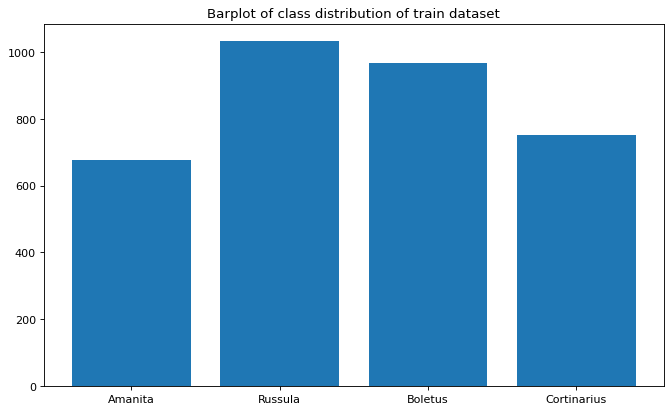

In [ ]:
TRAIN_DIR = './Dataset_4c_avg/train/'
plot_class_distribution(TRAIN_DIR, "train")

  0%|          | 0/4 [00:00<?, ?it/s]

Number of Amanita: 75, proportion: 0.19633507853403143
Number of Russula: 115, proportion: 0.3010471204188482
Number of Boletus: 108, proportion: 0.28272251308900526
Number of Cortinarius: 84, proportion: 0.2198952879581152


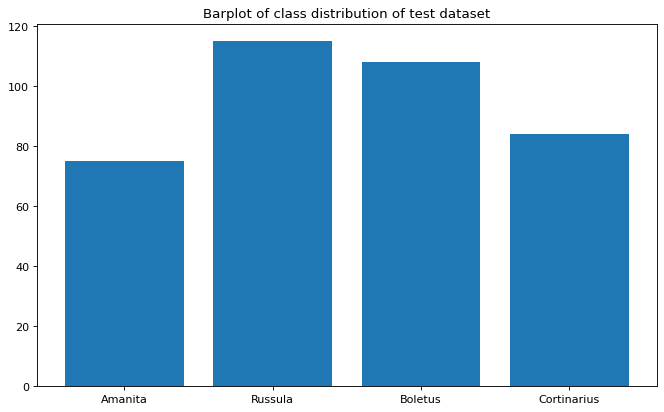

In [ ]:
TEST_DIR = './Dataset_4c_avg/test/'
plot_class_distribution(TEST_DIR, "test")



```
# Questo è formattato come codice
```

## Models loading

In [ ]:
from tensorflow.keras.models import load_model

from_scratch_path = "/content/drive/Shareddrives/Progetto_CIDL/Models/CNN_from_scratch.h5"
VGG16_nda_path = "/content/drive/Shareddrives/Progetto_CIDL/Models/CNN_pretrained_VGG16_copy.h5" 
VGG16_path = "/content/drive/Shareddrives/Progetto_CIDL/Models/CNN_pretrained_VGG16.h5"
EffNet_path = "/content/drive/Shareddrives/Progetto_CIDL/Models/CNN_pretrained_EfficientNetB7.h5"

from_scratch_model = load_model(from_scratch_path)
VGG16_nda_model = load_model(VGG16_nda_path)
VGG16_model = load_model(VGG16_path)
EffNet_model = load_model(EffNet_path)


##Testing

In [ ]:
loss, accuracy = from_scratch_model.evaluate(test_data_1, 
                                    verbose=2, 
                                    use_multiprocessing=True, 
                                    workers=2)
print(f'Model 1 performance on test images:\nAccuracy = {accuracy}\nLoss = {loss}')

loss, accuracy = VGG16_nda_model.evaluate(test_data, 
                                    verbose=2, 
                                    use_multiprocessing=True, 
                                    workers=2)
print(f'Model 2 performance on test images:\nAccuracy = {accuracy}\nLoss = {loss}')

loss, accuracy = VGG16_model.evaluate(test_data, 
                                    verbose=2, 
                                    use_multiprocessing=True, 
                                    workers=2)
print(f'Model 3 performance on test images:\nAccuracy = {accuracy}\nLoss = {loss}')

loss, accuracy = EffNet_model.evaluate(test_data,
                                    verbose=2, 
                                    use_multiprocessing=True, 
                                    workers=2)
print(f'Model 4 performance on test images:\nAccuracy = {accuracy}\nLoss = {loss}')

6/6 - 15s - loss: 0.9286 - accuracy: 0.6309 - 15s/epoch - 2s/step
Model 1 performance on test images:
Accuracy = 0.6308900713920593
Loss = 0.9285711050033569
6/6 - 18s - loss: 2.6126 - accuracy: 0.9293 - 18s/epoch - 3s/step
Model 2 performance on test images:
Accuracy = 0.9293193817138672
Loss = 2.61262845993042
6/6 - 4s - loss: 7.5444 - accuracy: 0.7592 - 4s/epoch - 728ms/step
Model 3 performance on test images:
Accuracy = 0.7591623067855835
Loss = 7.5444183349609375
6/6 - 24s - loss: 0.1407 - accuracy: 0.9581 - 24s/epoch - 4s/step
Model 4 performance on test images:
Accuracy = 0.9581151604652405
Loss = 0.14069870114326477


In [ ]:
from pandas.core.dtypes.common import classes
import numpy as np
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report, RocCurveDisplay
from sklearn.utils import class_weight

y_test = test_generator_1.classes
nb_samples = 382 # number of test images

# Model 1
FS_pred = from_scratch_model.predict_generator(test_generator_1, nb_samples // BATCH_SIZE+1)
FS_pred = np.argmax(FS_pred, axis=1)
# Model 2
VGG16_nda_pred = VGG16_nda_model.predict_generator(test_generator_2, nb_samples // BATCH_SIZE+1)
VGG16_nda_pred = np.argmax(VGG16_nda_pred, axis=1)
# Model 3
VGG16_pred = VGG16_model.predict_generator(test_generator_3, nb_samples // BATCH_SIZE+1)
VGG16_pred = np.argmax(VGG16_pred, axis=1)
# Model 4
EN_pred = EffNet_model.predict_generator(test_generator_4, nb_samples // BATCH_SIZE+1)
EN_pred = np.argmax(EN_pred, axis=1)


<ipython-input-13-a5de08e0c800>:12: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  FS_pred = from_scratch_model.predict_generator(test_generator_1, nb_samples // BATCH_SIZE+1)
<ipython-input-13-a5de08e0c800>:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  VGG16_nda_pred = VGG16_nda_model.predict_generator(test_generator_2, nb_samples // BATCH_SIZE+1)
<ipython-input-13-a5de08e0c800>:18: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  VGG16_pred = VGG16_model.predict_generator(test_generator_3, nb_samples // BATCH_SIZE+1)
<ipython-input-13-a5de08e0c800>:21: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, wh

<bound method DatasetV2.get_single_element of <BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>>


In [ ]:
from sklearn.metrics import roc_auc_score
y_test = test_generator_1.classes

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3]


In [ ]:
print(EN_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 0 3 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2
 2 2 2 2 2 3 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 0 2 2 0 2 2 2 2 2
 2 2 3 2 2 2 2 2 0 3 3 3 3 3 3 2 3 3 3 3 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3]


In [ ]:
def reshape_for_auc(t_test):
  t_true = []
  for i in range(len(t_test)):
    if t_test[i] == 0:
      t_true += [[1, 0, 0, 0]]
    elif t_test[i] == 1:
      t_true += [[0, 1, 0, 0]]
    elif t_test[i] == 2:
      t_true += [[0, 0, 1, 0]]
    else:
      t_true += [[0, 0, 0, 1]]
  return t_true

In [ ]:
y_true = reshape_for_auc(y_test)
FS_true = reshape_for_auc(FS_pred)
VGG16_nda_true = reshape_for_auc(VGG16_nda_pred)
VGG16_true = reshape_for_auc(VGG16_pred)
EN_true = reshape_for_auc(EN_pred)



In [ ]:
print(f"From Scratch AUC score: {roc_auc_score(y_true, FS_true, multi_class='ovr')}")
print(f"VGG16 no DA AUC score: {roc_auc_score(y_true, VGG16_nda_true, multi_class='ovr')}")
print(f"VGG16 AUC score: {roc_auc_score(y_true, VGG16_true, multi_class='ovr')}")
print(f"EfficentNetB7 AUC score: {roc_auc_score(y_true, EN_true, multi_class='ovr')}")

From Scratch AUC score: 0.7347327212962769
VGG16 no DA AUC score: 0.9423921858135799
VGG16 AUC score: 0.8175394150906587
EfficentNetB7 AUC score: 0.965058763895464


In [ ]:
labels = []
for i in range(len(y_test)):
  labels.append([y_test[i], FS_pred[i], VGG16_nda_pred[i], VGG16_pred[i], EN_pred[i]])

In [ ]:
misclassifications = [len(label) - label.count(label[0]) for label in labels]
print(misclassifications)

[1, 1, 2, 2, 3, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0, 2, 1, 1, 1, 1, 0, 1, 2, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 3, 4, 1, 2, 1, 1, 0, 1, 2, 1, 1, 3, 1, 0, 0, 0, 2, 0, 1, 3, 2, 2, 1, 2, 2, 4, 3, 3, 4, 1, 1, 0, 2, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 0, 0, 0, 0, 0, 1, 1, 0, 1, 2, 1, 1, 2, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 1, 0, 1, 0, 1, 2, 2, 0, 0, 0, 1, 0, 0, 0, 3, 2, 2, 0, 0, 0, 0, 2, 1, 1, 1, 2, 1, 1, 0, 2, 3, 2, 0, 1, 0, 1, 1, 2, 4, 1, 1, 1, 2, 1, 1, 4, 0, 1, 1, 0, 2, 0, 2, 2, 3, 0, 0, 1, 1, 1, 1, 4, 1, 0, 2, 0, 1, 1, 0, 1, 0, 0, 4, 1, 2, 2, 1, 0, 1, 0, 0, 0, 0, 1, 0, 3, 0, 1, 0, 1, 3, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 2, 1, 1, 0, 1, 2, 1, 0, 0, 1, 1, 1, 2, 1, 0, 1, 0, 0, 0, 0, 2, 2, 2, 4, 1, 1, 0, 

Misclassified images from 4 classifiers:  8
Misclassified images from 3 classifiers:  12
Misclassified images from 2 classifiers:  51
Misclassified images from 1 classifiers:  119


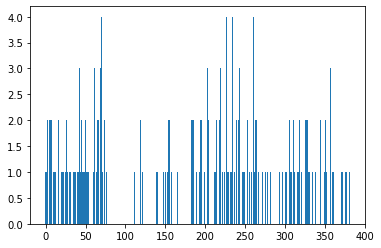

In [ ]:
print("Misclassified images from 4 classifiers: ", len([1 for misclassification in misclassifications if misclassification == 4]))
print("Misclassified images from 3 classifiers: ", len([1 for misclassification in misclassifications if misclassification == 3]))
print("Misclassified images from 2 classifiers: ", len([1 for misclassification in misclassifications if misclassification == 2]))
print("Misclassified images from 1 classifiers: ", len([1 for misclassification in misclassifications if misclassification == 1]))
plt.bar(range(len(labels)),misclassifications)
plt.show()

In [ ]:
misclassifications_classifier = []
for i in range(len(labels)):
  if labels[i].count(labels[i][0]) == len(labels[i]): # if all classifiers are good ad recognizing the image
    misclassifications_classifier.append([]) 
    continue
  wrong_classifiers = [index for index, predicted_class in enumerate(labels[i]) if predicted_class != labels[i][0]]
  misclassifications_classifier.append(wrong_classifiers)

In [ ]:
print(misclassifications_classifier)

[[1], [3], [1, 3], [1, 3], [1, 2, 3], [1, 3], [1, 3], [1, 3], [1, 3], [1], [1], [3], [1], [1], [1], [], [1, 3], [], [], [1, 3], [1], [3], [3], [3], [], [1], [1, 2], [3], [], [], [3], [1], [], [1], [3], [1], [1], [1], [1], [], [1], [1], [1, 2, 3], [1, 2, 3, 4], [1], [1, 3], [1], [1], [], [3], [1, 3], [1], [1], [1, 2, 3], [1], [], [], [], [1, 3], [], [1], [1, 2, 3], [1, 3], [1, 3], [1], [2, 3], [1, 3], [1, 2, 3, 4], [1, 3, 4], [1, 2, 3], [1, 2, 3, 4], [1], [1], [], [1, 3], [], [1], [1], [1], [], [], [], [], [], [], [], [], [1], [1], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [2], [], [], [], [], [], [], [], [1, 3], [], [3], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [1], [1], [1, 2], [], [], [], [], [], [3], [1], [], [1], [1, 2], [1], [1], [1, 3], [1, 3], [], [], [1], [], [], [], [], [], [], [1], [], [], [], [], [], [], [1], [], [], [], [], [], [], [], [], [], [], [1, 3], [1, 3], [1, 3], [], [], [], [1], [], [1], [], [

In [ ]:
print("Images that are misclassified by all classifiers: ", len([1 for misclassification in misclassifications_classifier if len(misclassification) == 4]))
print("--------")
print("Images that are misclassified only by FromScratch: ", len([1 for misclassification in misclassifications_classifier 
                                                                 if len(misclassification) == 1 and 1 in misclassification]))
print("Images that are correctly classified only by FromScratch: ", len([1 for misclassification in misclassifications_classifier 
                                                                 if len(misclassification) == 3 and 1 not in misclassification]))
print("--------")
print("Images that are misclassified only by VGG16_no_DA: ", len([1 for misclassification in misclassifications_classifier 
                                                                 if len(misclassification) == 1 and 2 in misclassification]))
print("Images that are correctly classified only by VGG16_no_DA: ", len([1 for misclassification in misclassifications_classifier 
                                                                 if len(misclassification) == 3 and 2 not in misclassification]))
print("--------")
print("Images that are misclassified only by VGG16: ", len([1 for misclassification in misclassifications_classifier 
                                                                 if len(misclassification) == 1 and 3 in misclassification]))
print("Images that are correctly classified only by VGG16: ", len([1 for misclassification in misclassifications_classifier 
                                                                 if len(misclassification) == 3 and 3 not in misclassification]))
print("--------")
print("Images that are misclassified only by EfficientNet: ", len([1 for misclassification in misclassifications_classifier 
                                                                 if len(misclassification) == 1 and 4 in misclassification]))
print("Images that are correctly classified only by EfficientNet: ", len([1 for misclassification in misclassifications_classifier 
                                                                 if len(misclassification) == 3 and 4 not in misclassification]))

Images that are misclassified by all classifiers:  8
--------
Images that are misclassified only by FromScratch:  79
Images that are correctly classified only by FromScratch:  2
--------
Images that are misclassified only by VGG16_no_DA:  3
Images that are correctly classified only by VGG16_no_DA:  3
--------
Images that are misclassified only by VGG16:  34
Images that are correctly classified only by VGG16:  0
--------
Images that are misclassified only by EfficientNet:  3
Images that are correctly classified only by EfficientNet:  7


In [ ]:
images =  tf.concat([data_batch for data_batch, labels_batch in test_data], axis = 0)
# print(images)


In [ ]:
numpy_images=np.concatenate([data_batch for data_batch, labels_batch in test_data], axis = 0)

In [ ]:
total_misclassification_indexes = [i for i in range(len(misclassifications_classifier)) if len(misclassifications_classifier[i]) == 4]


In [ ]:
print(total_misclassification_indexes)

[43, 67, 70, 227, 234, 250, 261, 329]


In [ ]:
conto = 1
for index in total_misclassification_indexes:
  value = y_test[index]
  if value == 0:
    print(conto)
    print('ok')
  conto = conto + 1

1
ok
2
ok
3
ok


In [ ]:
import glob
import matplotlib.pyplot as plt
import skimage.io
import skimage.color
import skimage.filters

In [ ]:
DIR = test_path

ama = os.listdir(DIR + "/Amanita")
ama_img = []
for elem in ama:
  ama_img.append(DIR + "/Amanita/" + elem)
bol = os.listdir(DIR + "/Boletus")
bol_img = []
for elem in bol:
  bol_img.append(DIR + "/Boletus/" + elem)
cor = os.listdir(DIR + "/Cortinarius")
cor_img = []
for elem in cor:
  cor_img.append(DIR + "/Cortinarius/" + elem)
rus = os.listdir(DIR + "/Russula")
rus_img = []
for elem in rus:
  rus_img.append(DIR + "/Russula/" + elem)

total_images = ama_img + bol_img + cor_img + rus_img
'''
total_images.append(inf_img)
total_images.append(NoF_img)
total_images.append(Ate_img)
'''

'\ntotal_images.append(inf_img)\ntotal_images.append(NoF_img)\ntotal_images.append(Ate_img)\n'

In [ ]:
total_images

['./Dataset_4c_avg/test//Amanita/006_862rFWvLb4I.jpg',
 './Dataset_4c_avg/test//Amanita/018_fu20lV1Ks10.jpg',
 './Dataset_4c_avg/test//Amanita/504_e21_MNX_8YQ.jpg',
 './Dataset_4c_avg/test//Amanita/008_euaqSUZFtMY.jpg',
 './Dataset_4c_avg/test//Amanita/626_C7_xmq1ySNI.jpg',
 './Dataset_4c_avg/test//Amanita/715_VO6ANDVE-KQ.jpg',
 './Dataset_4c_avg/test//Amanita/535_N16i3fN7CWo.jpg',
 './Dataset_4c_avg/test//Amanita/071_SDRvTCrFXG8.jpg',
 './Dataset_4c_avg/test//Amanita/512_yaPzIQxfG-U.jpg',
 './Dataset_4c_avg/test//Amanita/098_kZeLGttR7iU.jpg',
 './Dataset_4c_avg/test//Amanita/592_3wJn34f0ewY.jpg',
 './Dataset_4c_avg/test//Amanita/231_GrW4eRdqorw.jpg',
 './Dataset_4c_avg/test//Amanita/575_EEcOtxtcwl4.jpg',
 './Dataset_4c_avg/test//Amanita/772_514z_qhbN1E.jpg',
 './Dataset_4c_avg/test//Amanita/562_F1Lhj44S04s.jpg',
 './Dataset_4c_avg/test//Amanita/100_w6tcyq1AMVk.jpg',
 './Dataset_4c_avg/test//Amanita/021_2-PKYWYCnqU.jpg',
 './Dataset_4c_avg/test//Amanita/077_SXUuHdu9t_Y.jpg',
 './Datase

./Dataset_4c_avg/test//Amanita/181_tBFIwVV_zjc.jpg
./Dataset_4c_avg/test//Amanita/083_GAJUFRatKvg.jpg
./Dataset_4c_avg/test//Amanita/717_vlDmzuYG5og.jpg
./Dataset_4c_avg/test//Cortinarius/208_CszwVrklW5U.jpg
./Dataset_4c_avg/test//Cortinarius/052_fBYUqgcRGeQ.jpg
./Dataset_4c_avg/test//Cortinarius/786_NTOO1CLhDKM.jpg
./Dataset_4c_avg/test//Cortinarius/826_0he7lOw9gjE.jpg
./Dataset_4c_avg/test//Russula/095_DcLBgv876UQ.jpg


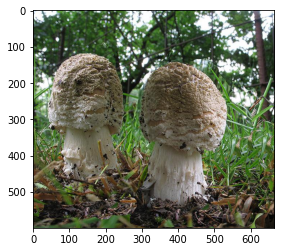

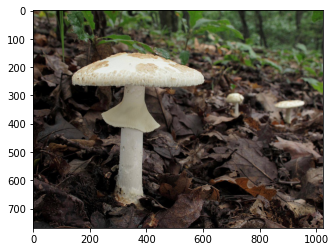

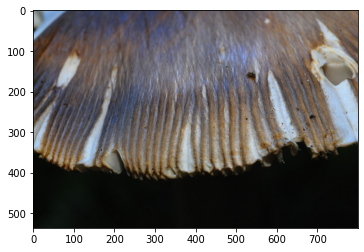

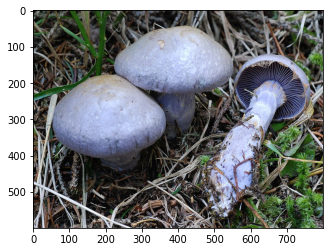

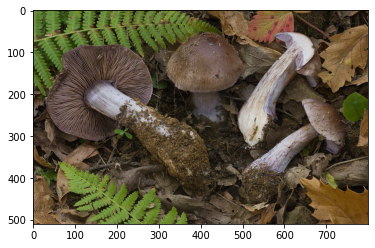

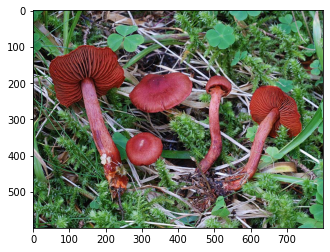

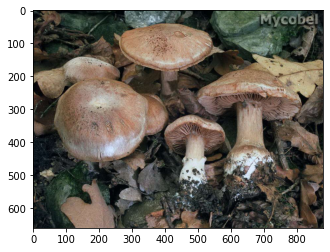

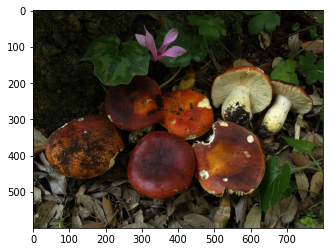

In [ ]:
for index in total_misclassification_indexes:
  image = skimage.io.imread(total_images[index])
  fig, ax = plt.subplots()
  plt.imshow(image)
  print(total_images[index])
  #plt.show(image)
  